# Extract single reads

Date: 26 Jan 2025

Using https://github.com/MichalRozenwald/epiCausality/blob/main/Extract_single_reads_%26_LR_2024Apr16.ipynb 
and https://github.com/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb 

In [1]:
from dimelo import parse_bam, plot_enrichment_profile, plot_reads, load_processed, utils
import pysam
import platform

import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.axes import Axes
import numpy as np
import pandas as pd

print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

#  Pyton version
import sys
print(sys.version)
     

modkit found with expected version 0.2.4
System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [2]:
ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta') #'./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')

In [3]:

t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'

ref_seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162, 206586192) #t2t v11: 206586162,206586192)
# seq = pysam.FastaFile(ref_genome_v1_0_gm_path).fetch('chr1',206586331, 206586361) #t2t v11: 206586162,206586192)
print(ref_seq), print(len(ref_seq))
ref_seq_list =  [s for s in ref_seq]
# plt.xticks(range(len(ref_seq_list)), ref_seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC
30


In [4]:
output_dir = Path("./dimelo_v2_output")
# Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir

PosixPath('dimelo_v2_output')

In [5]:
! ls "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v1_1/"

align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
summary_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.tsv


In [6]:
unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"


No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.99 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

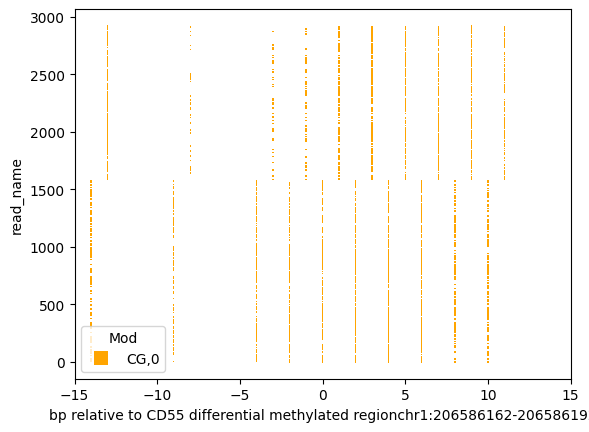

In [7]:
def extract_from_bam(bam_path, ref_genome_file, output_dir, 
                    window_size=None, threshold_mC=0.99, num_cores=32,
                    regions = 'chr1:206586162-206586192',
                    motifs=['CG,0'],
                    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',):
    """
    Processes a BAM file using the parse_bam.extract function and plots the extracted reads.

    Parameters:
        bam_path (str): Path to the input BAM file.
        ref_genome_file (str): Path to the reference genome file.
        output_dir (str): Directory to store output files.
        window_size (int, optional): Window size for extraction. Defaults to None.
        threshold_mC (float, optional): Threshold for methylation. Defaults to 0.99.
        num_cores (int, optional): Number of cores for processing. Defaults to 32.

    Returns:
        extract_file, extract_regions
    """

    extract_file, extract_regions  = parse_bam.extract(
        input_file=bam_path,
        output_name=output_name,
        ref_genome=ref_genome_file,
        output_directory=output_dir,
        regions=regions,
        motifs=motifs,
        thresh=threshold_mC,
        window_size=window_size,
    )

    plot_reads.plot_reads(
        extract_file,
        t2t_v1_1_cd55_30bps,
        motifs=motifs,
        window_size=window_size,
        sort_by=['shuffle', 'strand'],
        s=1
    )

    plt.xlabel('bp relative to CD55 differential methylated region' + str(regions) )
    plt.show()

    return(extract_file, extract_regions )


# Example usage
bam_path = unedited_bam_path
threshold_mC=0.99

window_size = None # 4000
# window_size = 4000

t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
regions = t2t_v1_1_cd55_30bps

motifs=['CG,0']
output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09'
# outname = f'cd55_window{window_size}'
num_cores = 32


extract_file, extract_regions = extract_from_bam(
    bam_path=unedited_bam_path,
    ref_genome_file=ref_genome_v1_1_file,
    output_dir=output_dir,
    window_size=window_size,   # 4000,
    threshold_mC=threshold_mC,  # 0.99
    regions = regions,         # 'chr1:206586162-206586192',
    motifs=motifs,
    output_name=output_name, #'cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
)


In [8]:

# extract_from_bam(
#     bam_path=unedited_bam_path,
#     ref_genome_file=ref_genome_v1_1_file,
#     output_dir=output_dir,
#     window_size=window_size, # 4000,
#     threshold_mC= 0.75, #  threshold_mC, #0.99
#     regions = 'chr1:206586162-206586192',
#     output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
# )

In [9]:
extract_file, extract_regions

(PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5'),
 PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/regions.processed.bed'))

In [10]:
# ! python3 -m pip install biopython

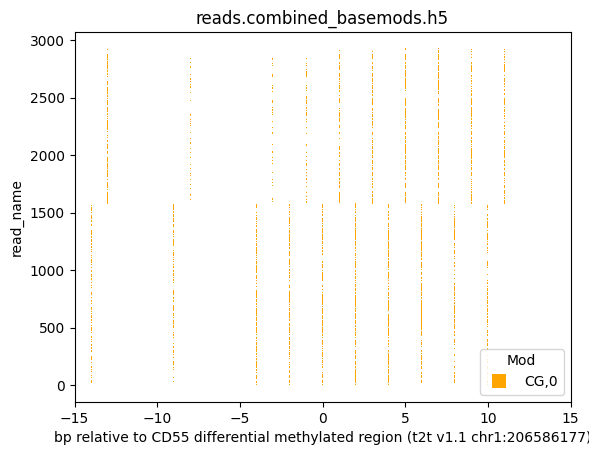

In [11]:
plot_reads.plot_reads(  
    extract_file,
    t2t_v1_1_cd55_30bps, # "chr1:206586162-206586192", #bed_region,
    ['CG,0'],
    window_size = window_size, #4000,
    sort_by=['shuffle', 'strand'],
    thresh=threshold_mC,  # 0.99
    # s=3
)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title(Path(extract_file).name)
plt.show()
     


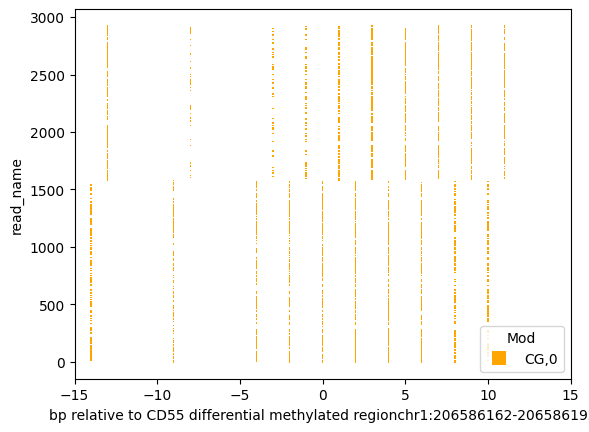

In [12]:
plot_reads.plot_reads(
    extract_file,
    t2t_v1_1_cd55_30bps,
    motifs=motifs,
    window_size=window_size,
    sort_by=['shuffle', 'strand'],
    s=1
)

plt.xlabel('bp relative to CD55 differential methylated region' + str(regions) )
plt.show()

# Using gm12878_deepCTCF_updated_extract_reads
 https://github.com/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb 

In [13]:
extract_file

PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5')

In [14]:
reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
              file=extract_file,
              regions=regions,
              motifs=motifs,
              window_size=None, #window_size,
)
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
    
# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')
df

,read_name,mod,pos
0,3,"CG,0",11
1,4,"CG,0",-13
2,5,"CG,0",7
3,9,"CG,0",-13
4,9,"CG,0",1
...,...,...,...
3120,2917,"CG,0",-13
3121,2918,"CG,0",-8
3122,2918,"CG,0",5
3123,2918,"CG,0",7


In [15]:
len(np.unique(df['read_name']))

981

In [16]:

df['pos_shifted'] = df['pos'] + 15
df

,read_name,mod,pos,pos_shifted
0,3,"CG,0",11,26
1,4,"CG,0",-13,2
2,5,"CG,0",7,22
3,9,"CG,0",-13,2
4,9,"CG,0",1,16
...,...,...,...,...
3120,2917,"CG,0",-13,2
3121,2918,"CG,0",-8,7
3122,2918,"CG,0",5,20
3123,2918,"CG,0",7,22


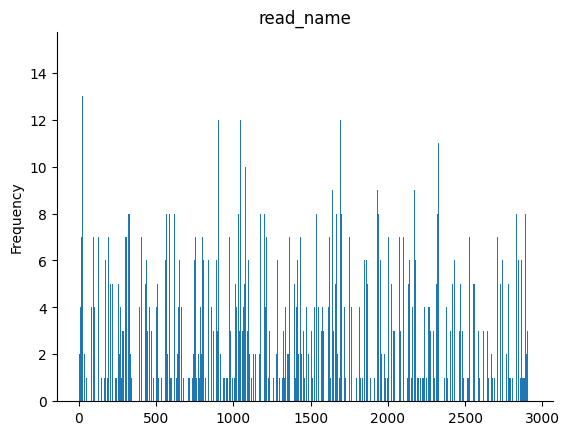

In [17]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=1600, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

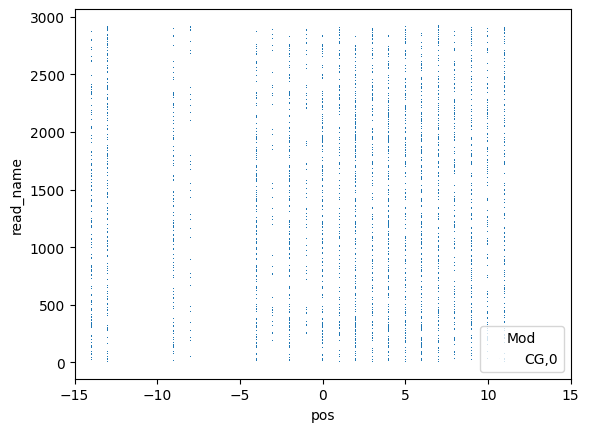

In [18]:
# Link to function https://github.com/streetslab/dimelo/blob/modkit_parsing_beta/dimelo/plot_reads.py#L56C1-L79C22

# mod_file_name = Path(mod_file_name)
# bed_file_name = Path(bed_file_name)
size = 0.5 # kwargs.pop('s', 0.5)

# palette = kwargs.pop('palette', {})
# merged_palette = {**utils.DEFAULT_COLORS, **palette}

axes = sns.scatterplot(
    data=df,
    x="pos",
    y="read_name",
    hue="mod",
    # palette=colors,
    s=size,
    marker="s",
    linewidth=0,
    # palette = merged_palette,
    # **kwargs
)
# Retrieve the existing legend
legend = axes.legend_
# legend = axes.get_legend

# Update legend properties
if legend is not None:
    legend.set_title('Mod')
    # for handle in legend.legendHandles:
    #     handle.set_markersize(10)  # Set a larger marker size for legend

relative = True
if relative:
    region1_start,region1_end,_ = next(iter(regions_dict.values()))[0]
    effective_window_size = (region1_end-region1_start)//2
    axes.set_xlim([-effective_window_size,effective_window_size])

# return axes

In [19]:
df.groupby("read_name").count() #["pos"].count()

,mod,pos,pos_shifted
read_name,,,
3,1,1,1
4,1,1,1
5,1,1,1
9,4,4,4
16,7,7,7
...,...,...,...
2902,3,3,3
2906,6,6,6
2917,1,1,1


In [20]:
len(read_names), len(np.unique(df['read_name']))

(3125, 981)

In [21]:
read_names_unique = np.unique(df['read_name'])
num_reads = len(read_names_unique)
num_reads

981

In [22]:
read_names_unique

array([   3,    4,    5,    9,   16,   22,   23,   24,   28,   32,   35,
         36,   38,   39,   41,   48,   50,   56,   59,   65,   69,   73,
         78,   80,   81,   82,   90,   92,   93,   95,  101,  105,  116,
        124,  126,  129,  130,  132,  137,  141,  142,  145,  147,  148,
        153,  156,  164,  166,  167,  168,  170,  172,  174,  176,  183,
        185,  186,  187,  188,  191,  192,  196,  200,  201,  203,  205,
        215,  216,  218,  219,  220,  227,  228,  229,  236,  241,  242,
        244,  245,  246,  248,  252,  255,  263,  267,  269,  274,  276,
        277,  279,  281,  283,  284,  288,  293,  296,  301,  302,  304,
        307,  312,  313,  316,  317,  319,  321,  324,  326,  327,  328,
        329,  333,  334,  339,  345,  348,  349,  354,  358,  362,  363,
        367,  370,  371,  375,  380,  383,  384,  387,  388,  393,  394,
        403,  404,  405,  417,  422,  425,  428,  431,  432,  433,  434,
        436,  439,  443,  445,  447,  449,  452,  4

In [23]:
reads_dict_nums = dict(enumerate(read_names_unique))
reads_dict_nums

{0: np.int64(3),
 1: np.int64(4),
 2: np.int64(5),
 3: np.int64(9),
 4: np.int64(16),
 5: np.int64(22),
 6: np.int64(23),
 7: np.int64(24),
 8: np.int64(28),
 9: np.int64(32),
 10: np.int64(35),
 11: np.int64(36),
 12: np.int64(38),
 13: np.int64(39),
 14: np.int64(41),
 15: np.int64(48),
 16: np.int64(50),
 17: np.int64(56),
 18: np.int64(59),
 19: np.int64(65),
 20: np.int64(69),
 21: np.int64(73),
 22: np.int64(78),
 23: np.int64(80),
 24: np.int64(81),
 25: np.int64(82),
 26: np.int64(90),
 27: np.int64(92),
 28: np.int64(93),
 29: np.int64(95),
 30: np.int64(101),
 31: np.int64(105),
 32: np.int64(116),
 33: np.int64(124),
 34: np.int64(126),
 35: np.int64(129),
 36: np.int64(130),
 37: np.int64(132),
 38: np.int64(137),
 39: np.int64(141),
 40: np.int64(142),
 41: np.int64(145),
 42: np.int64(147),
 43: np.int64(148),
 44: np.int64(153),
 45: np.int64(156),
 46: np.int64(164),
 47: np.int64(166),
 48: np.int64(167),
 49: np.int64(168),
 50: np.int64(170),
 51: np.int64(172),
 52:

In [24]:
reads_dict = dict()

for i in range(len(read_names_unique)):
  reads_dict[read_names_unique[i]] = i
reads_dict

{np.int64(3): 0,
 np.int64(4): 1,
 np.int64(5): 2,
 np.int64(9): 3,
 np.int64(16): 4,
 np.int64(22): 5,
 np.int64(23): 6,
 np.int64(24): 7,
 np.int64(28): 8,
 np.int64(32): 9,
 np.int64(35): 10,
 np.int64(36): 11,
 np.int64(38): 12,
 np.int64(39): 13,
 np.int64(41): 14,
 np.int64(48): 15,
 np.int64(50): 16,
 np.int64(56): 17,
 np.int64(59): 18,
 np.int64(65): 19,
 np.int64(69): 20,
 np.int64(73): 21,
 np.int64(78): 22,
 np.int64(80): 23,
 np.int64(81): 24,
 np.int64(82): 25,
 np.int64(90): 26,
 np.int64(92): 27,
 np.int64(93): 28,
 np.int64(95): 29,
 np.int64(101): 30,
 np.int64(105): 31,
 np.int64(116): 32,
 np.int64(124): 33,
 np.int64(126): 34,
 np.int64(129): 35,
 np.int64(130): 36,
 np.int64(132): 37,
 np.int64(137): 38,
 np.int64(141): 39,
 np.int64(142): 40,
 np.int64(145): 41,
 np.int64(147): 42,
 np.int64(148): 43,
 np.int64(153): 44,
 np.int64(156): 45,
 np.int64(164): 46,
 np.int64(166): 47,
 np.int64(167): 48,
 np.int64(168): 49,
 np.int64(170): 50,
 np.int64(172): 51,
 np.

In [25]:
padded_reads = np.zeros([num_reads, 30])
padded_reads

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
padded_reads.shape


(981, 30)

In [27]:
# SWITCH TO Nans -> to distriguish empty values from unmethylated
padded_reads = padded_reads + np.nan
padded_reads.shape, padded_reads

((981, 30),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [28]:
for i in range(len(df['read_name'])):
  # df['pos_shifted']:
  padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1
padded_reads

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan,  1., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [29]:
i = 0
reads_dict[df['read_name'][i]],

(0,)

In [30]:
df['read_name'][i]

np.int64(3)

In [31]:
padded_reads[reads_dict[df['read_name'][i]]]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1., nan, nan, nan])

In [32]:
df[df["read_name"] == df['read_name'][i]]

,read_name,mod,pos,pos_shifted
0,3,"CG,0",11,26


In [33]:
df["read_name"] 

0          3
1          4
2          5
3          9
4          9
        ... 
3120    2917
3121    2918
3122    2918
3123    2918
3124    2922
Name: read_name, Length: 3125, dtype: int64

In [34]:
padded_reads


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan,  1., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

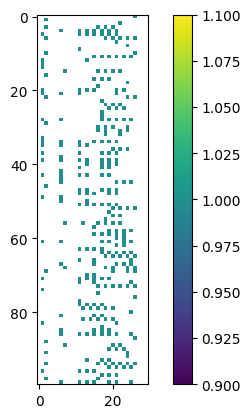

In [35]:

plt.imshow(padded_reads[:100]) # np.random.random((50,50)))
plt.colorbar()
plt.show()

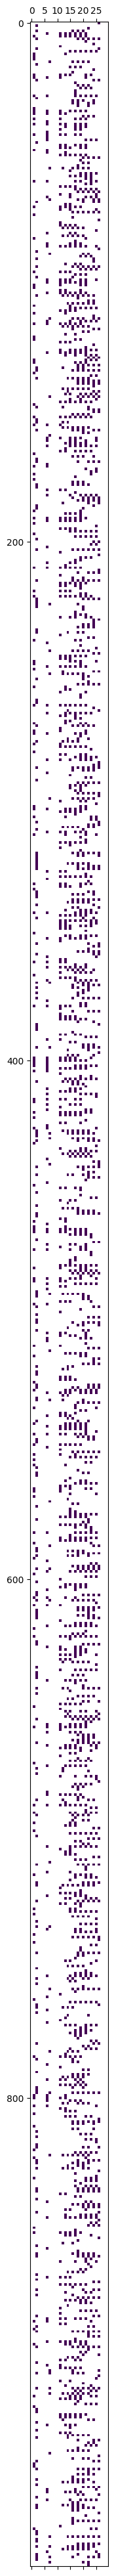

In [36]:


plt.figure(figsize=(10,50))
plt.matshow(padded_reads, fignum=1)


In [37]:
padded_reads_df = pd.DataFrame(padded_reads)
padded_reads_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
977,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
978,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
padded_reads_df.columns = ref_seq_list
padded_reads_df

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
977,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
978,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
padded_reads_df.describe()

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
count,0.0,140.0,193.0,0.0,0.0,0.0,133.0,38.0,0.0,0.0,...,189.0,221.0,191.0,142.0,168.0,122.0,147.0,0.0,0.0,0.0
mean,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
std,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
min,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
25%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
50%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
75%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
max,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [40]:
# Save mC profiles np.ARRAY!
padded_reads.shape, padded_reads

((981, 30),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan,  1., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan,  1., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [41]:
output_dir

PosixPath('dimelo_v2_output')

In [42]:
save_folder_path = output_dir # + "etracted_reads"
save_folder_path

PosixPath('dimelo_v2_output')

In [43]:
threshold_mC

0.99

In [44]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [45]:
# cd55_30pbRIO_padded_reads.npy
# TODO: add info, dates, path
save_name = "deepCTCF_thresh" + str(threshold_mC) + "_cd55_30pbRIO_padded_reads" 
save_name_np = save_name + ".npy"

np.save(Path(save_folder_path, save_name_np), padded_reads)

Path(save_folder_path, save_name_np) 

PosixPath('dimelo_v2_output/deepCTCF_thresh0.99_cd55_30pbRIO_padded_reads.npy')